# Import packages

Install instructions

* pipenv install
* pipenv run python -m spacy download es_core_news_lg

In [199]:
import pandas as pd
import json

# Setup the project
* Load spacy model for lemmatization
* Load nltk stopwords

In [200]:
import spacy

# Load the medium-sized Spanish model
nlp = spacy.load('es_core_news_lg')

In [201]:
import nltk
from nltk.corpus import stopwords

# Download NLTK stop words for various languages
nltk.download('stopwords')

# Get stop words for Spanish
spanish_stop_words = stopwords.words('spanish')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


* print out some stop words

In [202]:
print(spanish_stop_words[0:10])

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']


* extend stop words

In [269]:
spanish_stop_words.extend([
"mas",
"sino",
"esten",
"haber",
"hecho",
"si",
"cuya",
"siendo",
"hacen",
"unas",
"unos",
"sido",
"estan",
"ser",
"cuyo",
"hacer",
"poder",
"tener",
"w",
"ir",
"hora",
"millon",
"millones",
"hora",
"tampoco",
"tambien",
"traves",
"pues",
"ahora",
"actual",
"alguno",
"uno",
"dos",
"tres",
"cuatro",
"cinco",
"seis",
"siete"
"ocho"
"nueve",
"diez",
"primero",
"segundo",
"solo",
"ciento",
"parte",
"cada",
"deber",
"alla",
"doble",
"basico",
"mismo",
"asi",
"tras",
"senor",
"caso",
"aqui",
"caso",
"usar",
"solamente",
"parecer",
"ademas",
"tras",
"segun",
"ano",
"aun",
"vez",
"luego",
"dan",
"hoy",
"igual",
"dejar",
"claro",
"siempre",
"manera",
"dia",
"mes",
"decir",
"dicho",
"tipo",
"ultimo",
"momento",
"total",
"bien",
"dar",
"poner",
"despues",
"ninguno",
"ver",
])

# Load the data

In [270]:

def load_json_from_path(file_path):
    """
    Load JSON data from a file path.

    Parameters:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The JSON data loaded from the file.
    """
    with open(file_path, 'r', encoding="utf8") as file:
        json_data = json.load(file)
    return json_data



In [271]:
articles = load_json_from_path('./data/articles.json')

* Data description

Each article contains an **title**, an **url** and the **content**. Each paragraph is separated as an item inside content

In [272]:
len(articles)

14

In [273]:
articles[0]

{'title': 'Petro y la lucha de clases / Columna de Felipe López Caballero',
 'url': 'https://www.eltiempo.com/politica/gobierno/petro-y-la-lucha-de-clases-columna-de-felipe-lopez-caballero-3333631',
 'category': 'politic',
 'content': ['La explicación está en la narrativa que Petro y sus redes sociales han creado. Según esta: 1) Colombia ha estado gobernada durante 200 años por unas élites corruptas interesadas solamente en enriquecerse y perpetuarse en el poder.',
  '2) Con Petro llegaría el primer presidente de izquierda cuya preocupación son los pobres y la justicia social.',
  '3) Los dueños de Colombia no estarían dispuestos a ceder sus privilegios ante un exguerrillero que busca el cambio.',
  'Esa narrativa es simplista, efectista y dañina. Para comenzar, el problema no es que Petro sea un exguerrillero. Si el presidente fuera Antonio Navarro la economía estaría funcionando mejor y la polarización no estaría disparada. La mitad del estancamiento del PIB obedece a factores intern

# Data cleaning
* Remove special characters
* Remove stop words
* Apply lemmatization

In [274]:
import re
from unidecode import unidecode

def preprocess_text(text):
    
    text = unidecode(text) # Remove accents 
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower()) # Remove punctuation and convert to lowercase

    return text

def remove_stop_words(text, custom_stop_words):
    """
    Remove custom stop words from the input text.

    Args:
        text (str): Input text.
        custom_stop_words (list): List of custom stop words to be removed.

    Returns:
        str: Text with custom stop words removed.
    """
    stop_words = set(custom_stop_words)
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

def lemmatize(text):
    # Process the text
    doc = nlp(text)
    # Extract the lemma for each token in the text
    lemmas = [token.lemma_ for token in doc]
    return lemmas

* Load all articles in a single dataset

In [275]:
documents = [para for doc in articles for para in doc['content']]

* Apply cleaning

In [286]:
documents = [remove_stop_words(preprocess_text(' '.join(lemmatize(d))),spanish_stop_words) for d in documents]

* Data after cleaning

In [287]:
documents[0:3]

['explicacion narrativo petro red social crear colombia gobernado elite corrupto interesado enriquecer perpetuar',
 'petro llegar presidente izquierdo preocupacion pobre justicia social',
 'dueno colombia dispuesto ceder privilegio exguerrillero buscar cambio']

In [288]:
def text_to_network(words: list[str]):
    network_dictionary = []
    limit = len(words) - 3
    for idx, word in enumerate(words):
        if idx == limit:
            break
        network_dictionary.extend(
            [
                {"_from": word, "to": words[idx + 1], "weight": 3},
                {"_from": word, "to": words[idx + 2], "weight": 2},
                {"_from": word, "to": words[idx + 3], "weight": 1},
            ]
        )
    network_dictionary.extend([
        {"_from": words[-3], "to": words[-2], "weight": 3},
        {"_from": words[-3], "to": words[-1], "weight": 2},
        {"_from": words[-2], "to": words[-1], "weight": 3}
    ])
    return network_dictionary


In [283]:
network_dict_dataset = [] 
network_dict_dataset.extend([text_to_network(doc.split()) for doc in documents if len(doc.split())>=5])
network_dict_dataset = [relation for sentence in network_dict_dataset for relation in sentence]

In [289]:
network_df = pd.DataFrame(network_dict_dataset)

In [290]:
network_df[network_df['weight']==3].groupby(['_from','to']).agg(score=('weight', 'sum')).reset_index().shape

(2307, 3)

In [291]:
network_df[network_df['weight']==3].groupby(['_from','to']).agg(score=('weight', 'sum')).reset_index().sort_values('score', ascending=False).head(20)

,_from,to,score
1061,gustavo,petro,36
638,desplazamiento,forzado,27
1756,presidente,gustavo,27
576,delegacion,gobierno,18
323,clan,golfo,12
608,derechos,humanos,12
1591,partido,verde,12
1889,red,social,12
1078,hogar,desplazado,12
1694,poblacion,desplazado,12


In [23]:
#network_df[network_df.duplicated(subset=['_from','to'],keep=False)].sort_values(['_from','to'])

In [24]:
#network_df.groupby(['from','to']).count().sort_values(['weight'])

In [292]:
network_df.query('_from == "campana" and to =="presidencial"')

,_from,to,weight
1347,campana,presidencial,3
1473,campana,presidencial,3
1554,campana,presidencial,3


In [293]:
score_network_df = network_df.groupby(['_from','to']).agg(score=('weight', 'sum')).reset_index()

In [294]:
score_network_df.sort_values('score', ascending=False).head(10)

,_from,to,score
3111,gustavo,petro,36
5134,presidente,gustavo,27
1871,desplazamiento,forzado,27
5145,presidente,petro,24
1683,delegacion,gobierno,18
3163,hogar,desplazado,14
2605,fin,economico,12
5531,red,social,12
1785,derechos,humanos,12
4660,partido,verde,12


In [295]:
score_network_df.shape

(6717, 3)

In [28]:
#score_network_df.to_csv('newspaper.csv',index=False)

In [296]:
score_network_df = score_network_df[score_network_df['_from'] != score_network_df['to'] ]

In [297]:
len(score_network_df)

6697

<Axes: ylabel='Frequency'>

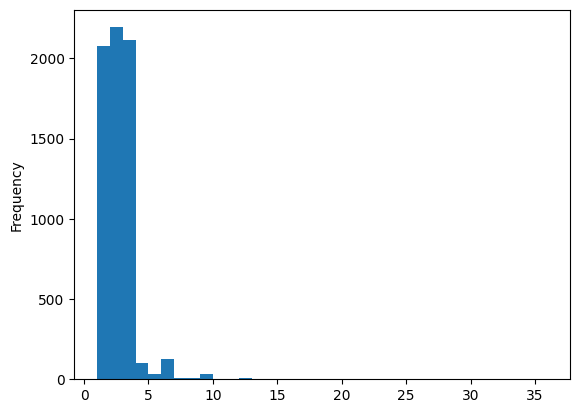

In [298]:
score_network_df.score.plot.hist(bins=35)

In [299]:
score_network_df[score_network_df['_from']=='ver']

,_from,to,score


In [300]:
score_network_df['_from'].value_counts().head(5)

_from
gobierno    84
petro       71
nacional    45
pais        42
colombia    41
Name: count, dtype: int64

In [263]:
import numpy as np

def normalize(v):
    norm=np.linalg.norm(v)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm

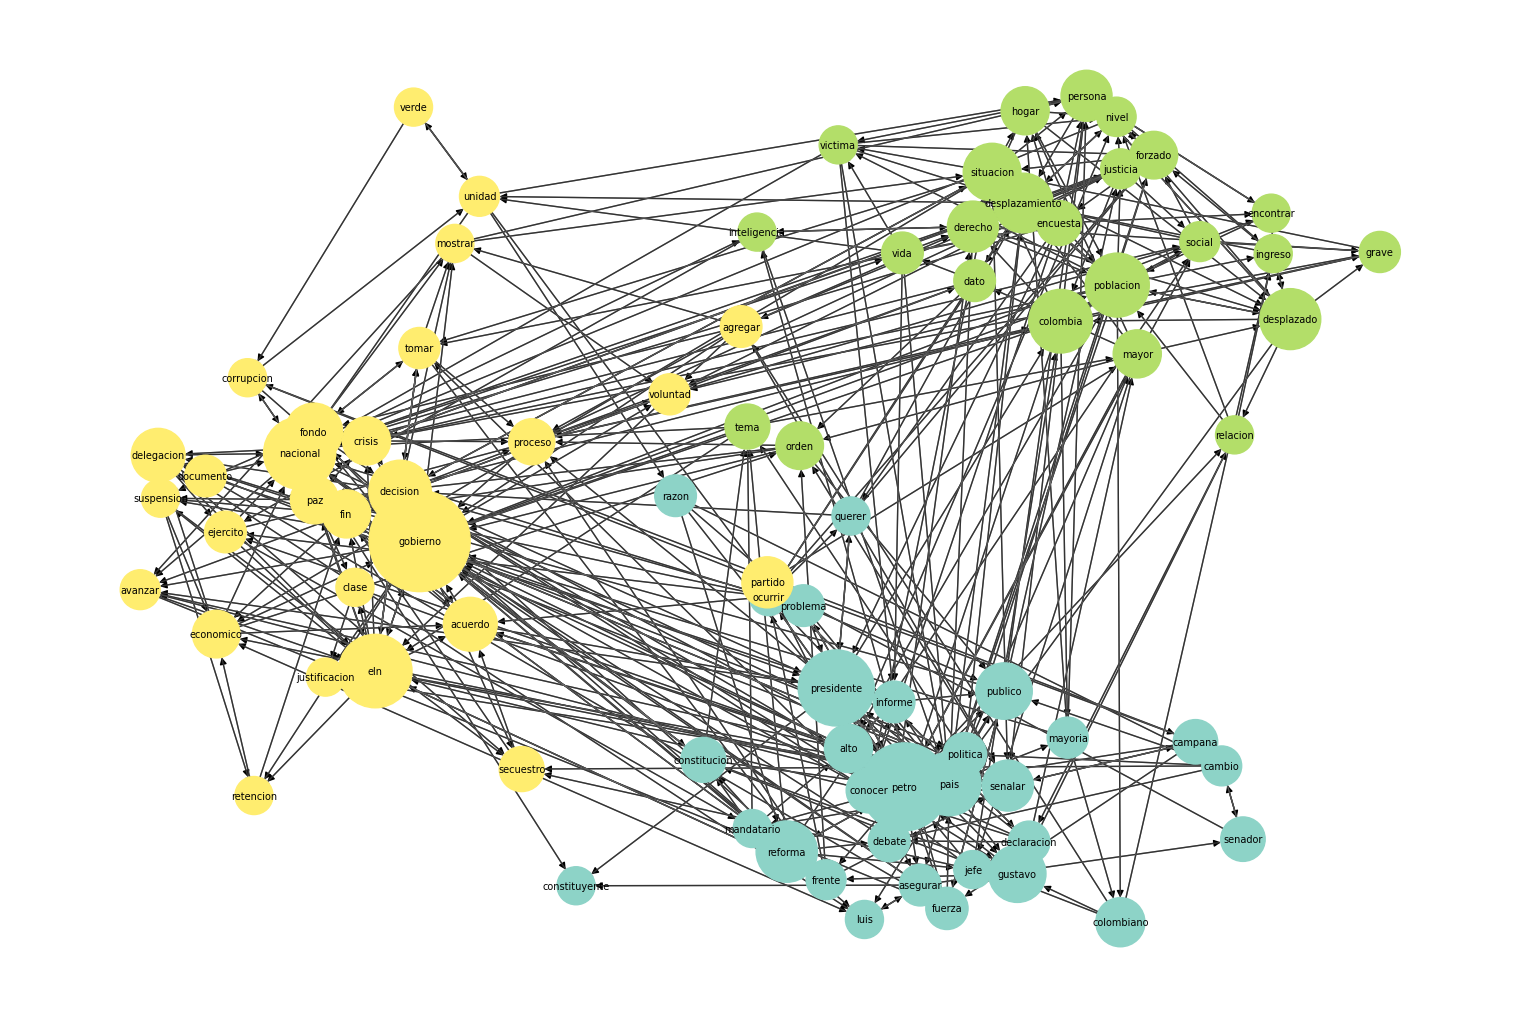

In [301]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
import numpy as np
G = nx.DiGraph()

# Add edges from the DataFrame with weights
for _, row in score_network_df[score_network_df.score >= 0].iterrows():
    G.add_edge(row['_from'], row['to'], weight=row['score'])

# Run the Louvain community detection algorithm
partition = community.greedy_modularity_communities(G, best_n=3)

# Create a dictionary where keys are community IDs and values are lists of nodes in that community
communities = {}
for idx, comm in enumerate(partition):
    for node in comm:
        communities[node] = idx

# Calculate the sum of scores for each node
node_scores = score_network_df.groupby(['_from'])['score'].sum().reset_index()

# Create a dictionary where keys are nodes and values are their corresponding scores
node_scores_dict = dict(zip(node_scores['_from'], node_scores['score']))

# Filter nodes based on the condition provided
#subgraph_filter1 = [node for node, community_id in communities.items() if community_id in [0,1,2] ]
subgraph_filter2 = [node for node, peso in node_scores_dict.items() if peso >=30]
#subgraph_nodes = list(set.intersection(set(subgraph_filter1),set(subgraph_filter2)))
subgraph = G.subgraph(subgraph_filter2)

# Calculate the sum of scores for nodes in the subgraph
subgraph_node_scores = {node: node_scores_dict.get(node, 0) for node in subgraph.nodes()}

# Define node sizes based on the sum of scores for nodes in the subgraph
node_sizes = [subgraph_node_scores[node] * 25 for node in subgraph.nodes()]

# Create a list of node colors based on their communities
node_colors = [communities[node] for node in subgraph.nodes()]

# Plot the subgraph with nodes sized proportionally to the sum of scores for each node
plt.figure(figsize=(15, 10))
pos = nx.kamada_kawai_layout(subgraph)

community_pos = {}
community_counts = {}
for node, community in zip(subgraph.nodes(),node_colors):
    if community in community_pos:
        community_pos[community] += np.array(pos[node])
        community_counts[community] += 1
    else:
        community_pos[community] = np.array(pos[node])
        community_counts[community] = 1

# Average the positions to find the center
for community in community_pos:
    community_pos[community] /= community_counts[community]

center = community_pos[0]+community_pos[1]+community_pos[2]

rc = 2
community_pos[0] += rc*normalize(community_pos[0]- center)
community_pos[1] += rc*normalize(community_pos[1]- center)
community_pos[2] += rc*normalize(community_pos[2]- center)

# Refine node positions to gravitate towards their community center
for node in pos:
    community = communities[node]
    pos[node] = 0.8 * np.array(pos[node]) + 0.2 * community_pos[community]
#pos = nx.spring_layout(subgraph, pos=pos,iterations=5)

nx.draw(subgraph, pos, with_labels=True, node_size=node_sizes, cmap=plt.cm.Set3, node_color=node_colors, font_size=7)
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', alpha=0.4)

plt.show()


In [200]:
from pyvis.network import Network

# Calculate degree centrality for each node
degree_centrality = nx.degree_centrality(G)

# Create a Pyvis network instance
#notebook=True
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", select_menu=True)

# Add nodes from the NetworkX graph G
for node, centrality in degree_centrality.items():
    net.add_node(node, size=centrality*100, color='skyblue')

# Add edges from the NetworkX graph G
for edge in G.edges():
    source, target = edge
    net.add_edge(source, target, title=f'{source}->{target}')

# Set options for the network
net.repulsion()

# Display the network inside the notebook
net.show("network_plot.html", notebook=False)


network_plot.html


# Modeling

Create a Count Vectorizer for create a word dictionary

In [14]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words=spanish_stop_words)

# Fit and transform the documents
X = vectorizer.fit_transform(documents)


In [15]:
vectorizer.get_feature_names_out()[0:5]

array(['abrir', 'abstracto', 'acabar', 'acertado', 'aclarar'],
      dtype=object)

In [16]:
def generate_ngrams(text, n):
    words = text.split()
    ngrams = []
    step = n-1
    for i in range(0,len(words) - n + 1,1):
        ngrams.append(' '.join(words[i:i + n]))
    return ngrams

## Analyzing Contextual Word Relationships Using a Two-Word Window

* Create word pair relationships

In [18]:
docs_pairs = []

# Generate pairs after removing stop words for each document
docs_pairs.extend([pair for d in documents for pair in generate_ngrams(remove_stop_words(d, spanish_stop_words),2)])

print(docs_pairs[0:3])

['explicacion narrativa', 'narrativa petro', 'petro red']


In [19]:
encoding = vectorizer.transform(docs_pairs).toarray()
co_ocurrences = encoding.T@encoding

names = vectorizer.get_feature_names_out().tolist()

np.fill_diagonal(co_ocurrences, 0)

co_ocurrences_df = pd.DataFrame(co_ocurrences, index=names, columns=names)

In [20]:
top_matches = co_ocurrences_df.sum(axis=1).sort_values(ascending=False).head(11)
top_matches

petro            32
presidente       17
constitucion     14
gobierno         12
deber            12
campana          11
constituyente    10
gustavo          10
colombia         10
razon             9
izquierda         8
dtype: int64

In [21]:
co_ocurrences_df.loc[top_matches.index,top_matches.index]

,petro,presidente,constitucion,gobierno,deber,campana,constituyente,gustavo,colombia,razon,izquierda
petro,0,0,0,0,0,1,0,5,0,1,0
presidente,0,0,0,0,0,0,0,3,0,0,2
constitucion,0,0,0,0,2,0,0,0,0,0,0
gobierno,0,0,0,0,1,0,0,0,0,0,0
deber,0,0,2,1,0,0,1,0,0,0,0
campana,1,0,0,0,0,0,0,0,0,0,0
constituyente,0,0,0,0,1,0,0,0,0,0,0
gustavo,5,3,0,0,0,0,0,0,0,0,0
colombia,0,0,0,0,0,0,0,0,0,0,0
razon,1,0,0,0,0,0,0,0,0,0,0


In [36]:
encoder = dict(enumerate(co_ocurrences_df.index.tolist()))

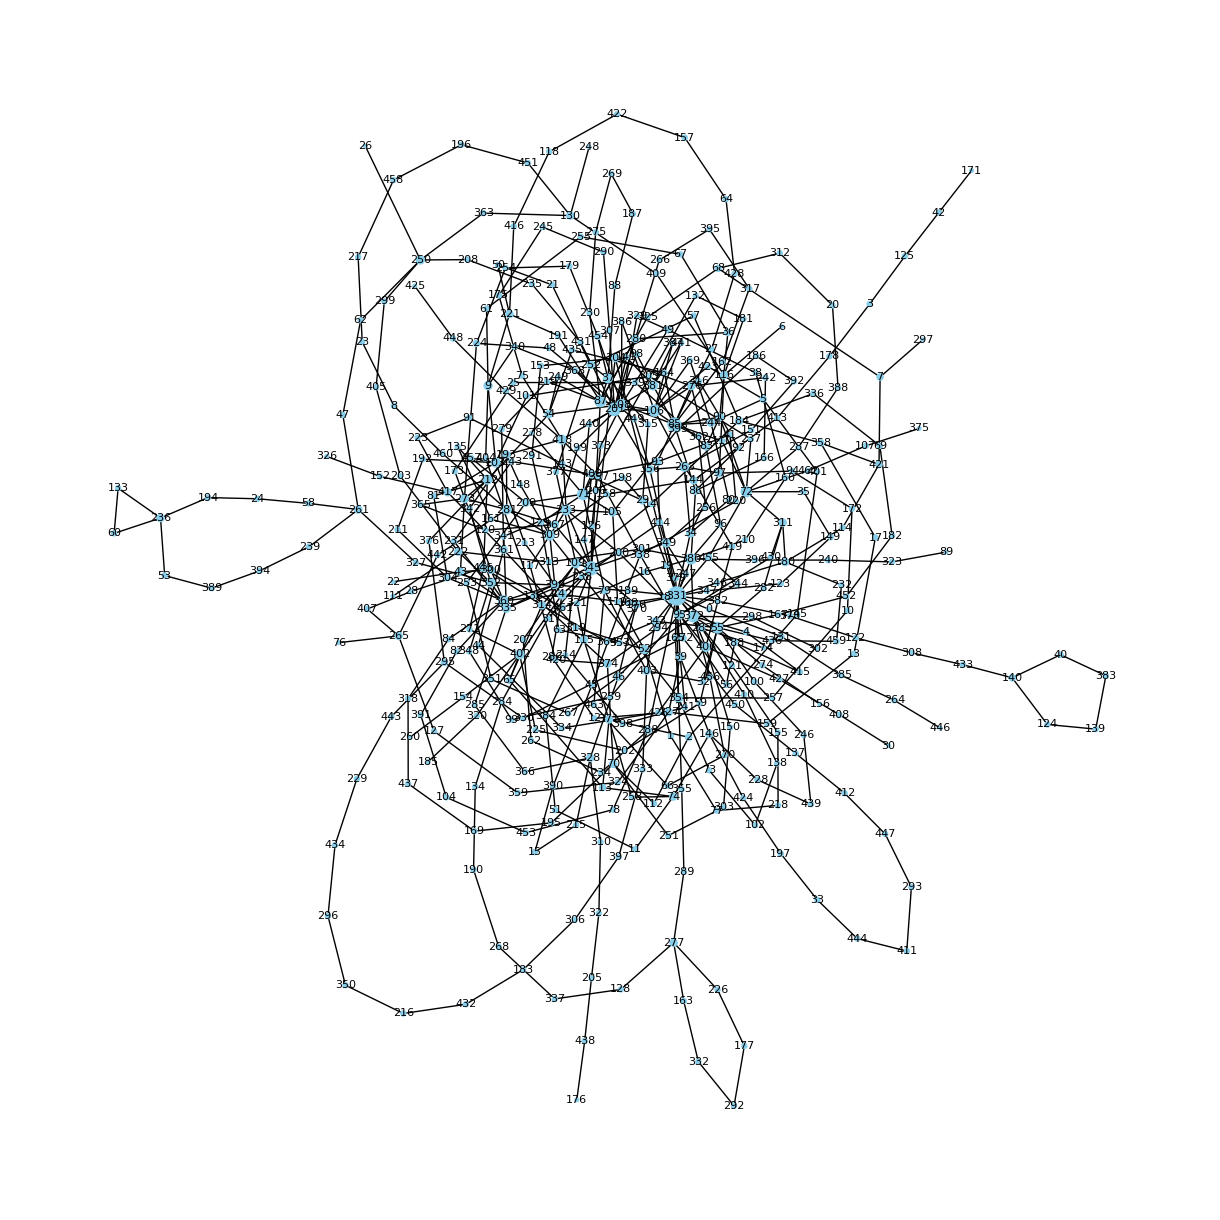

In [26]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Assuming co_ocurrences_df is your adjacency matrix DataFrame
# Convert the DataFrame to a numpy array
adjacency_matrix = co_ocurrences_df.values

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adjacency_matrix)

# Calculate degree centrality for each node
degree_centrality = nx.degree_centrality(G)

# Draw the graph
plt.figure(figsize=(12, 12))  # Adjust the figure size
pos = nx.kamada_kawai_layout(G)  # Use Kamada-Kawai layout for better organization
node_size = [v * 3000 for v in degree_centrality.values()]  # Adjust node size based on degree centrality
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=node_size, edge_color='black', linewidths=1, font_size=8)  # Adjust the font size

# Show plot
plt.show()


In [45]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:6]
[encoder[e] for e  in top_betweenness_nodes]


['petro', 'presidente', 'razon', 'elemento', 'gobierno', 'constitucion']

In [46]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Get the top 6 nodes by degree centrality
top_degree_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:6]
[encoder[e] for e  in top_degree_nodes]


['petro', 'constitucion', 'presidente', 'gobierno', 'deber', 'campana']

In [51]:
# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Get the top 6 nodes by closeness centrality
top_closeness_nodes = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:6]
[encoder[e] for e  in top_closeness_nodes]


['petro', 'primero', 'presidente', 'gustavo', 'exguerrillero', 'reforma']

In [74]:
encoding = vectorizer.transform(docs_pairs).toarray()
co_ocurrences = encoding.T@encoding

names = vectorizer.get_feature_names_out().tolist()

np.fill_diagonal(co_ocurrences, 0)

co_ocurrences_df = pd.DataFrame(co_ocurrences, index=names, columns=names)

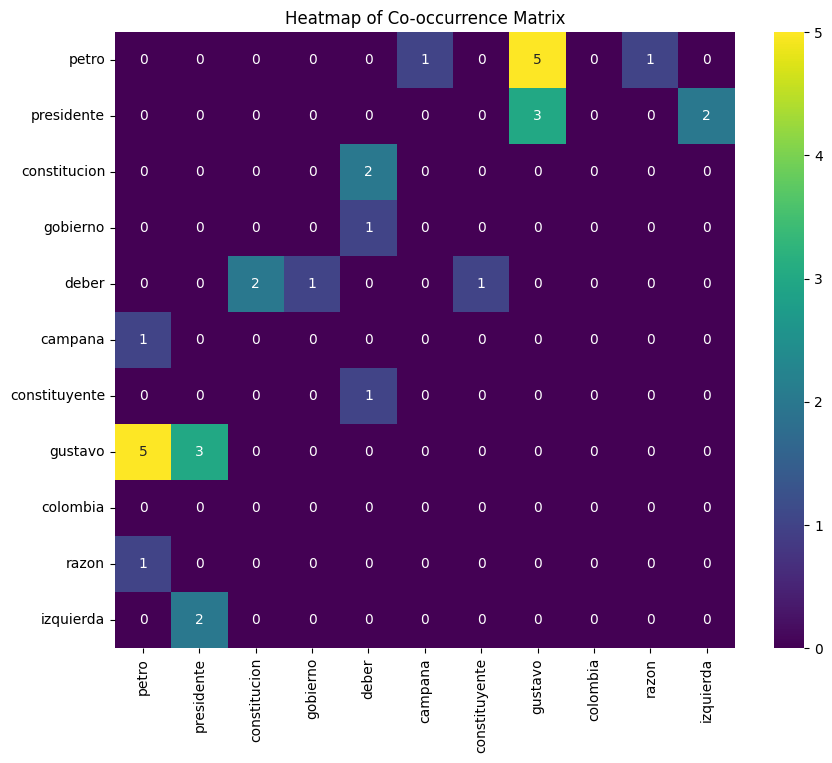

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'co_occurrences_df' is your DataFrame and 'top_matches' is a list or index slice defining the top matches.
# Filter the DataFrame to only include rows and columns from 'top_matches'
sub_matrix = co_ocurrences_df.loc[top_matches.index, top_matches.index]

# Create a heatmap
plt.figure(figsize=(10, 8))  # You can adjust the size to fit your specific needs
sns.heatmap(sub_matrix, annot=True, fmt="d", cmap='viridis')
plt.title('Heatmap of Co-occurrence Matrix')
plt.show()


## Analyzing Contextual Word Relationships Using a Three-Word Window

In [65]:
docs_group = []

# Generate pairs after removing stop words for each document
docs_group.extend([pair for d in documents for pair in generate_ngrams(remove_stop_words(d, spanish_stop_words),3)])

print(docs_group[0:3])

['explicacion narrativa petro', 'narrativa petro red', 'petro red social']


* Calculating co-occurences

In [66]:
encoding = vectorizer.transform(docs_group).toarray()
co_ocurrences = encoding.T@encoding

names = vectorizer.get_feature_names_out().tolist()

np.fill_diagonal(co_ocurrences, 0)

co_ocurrences_df = pd.DataFrame(co_ocurrences, index=names, columns=names)

In [67]:
top_matches = co_ocurrences_df.sum(axis=1).sort_values(ascending=False).head(11)
top_matches

petro            92
presidente       50
constitucion     42
deber            34
gobierno         34
campana          32
constituyente    30
gustavo          28
colombia         26
razon            26
pais             24
dtype: int64

In [68]:
co_ocurrences_df.loc[top_matches.index,top_matches.index]

,petro,presidente,constitucion,deber,gobierno,campana,constituyente,gustavo,colombia,razon,pais
petro,0,5,0,0,0,3,0,9,0,3,0
presidente,5,0,0,0,0,0,1,6,0,0,0
constitucion,0,0,0,4,0,0,0,1,0,0,0
deber,0,0,4,0,2,0,2,0,0,0,0
gobierno,0,0,0,2,0,0,0,0,1,0,0
campana,3,0,0,0,0,0,0,0,0,0,0
constituyente,0,1,0,2,0,0,0,0,0,0,0
gustavo,9,6,1,0,0,0,0,0,0,0,0
colombia,0,0,0,0,1,0,0,0,0,0,0
razon,3,0,0,0,0,0,0,0,0,0,0


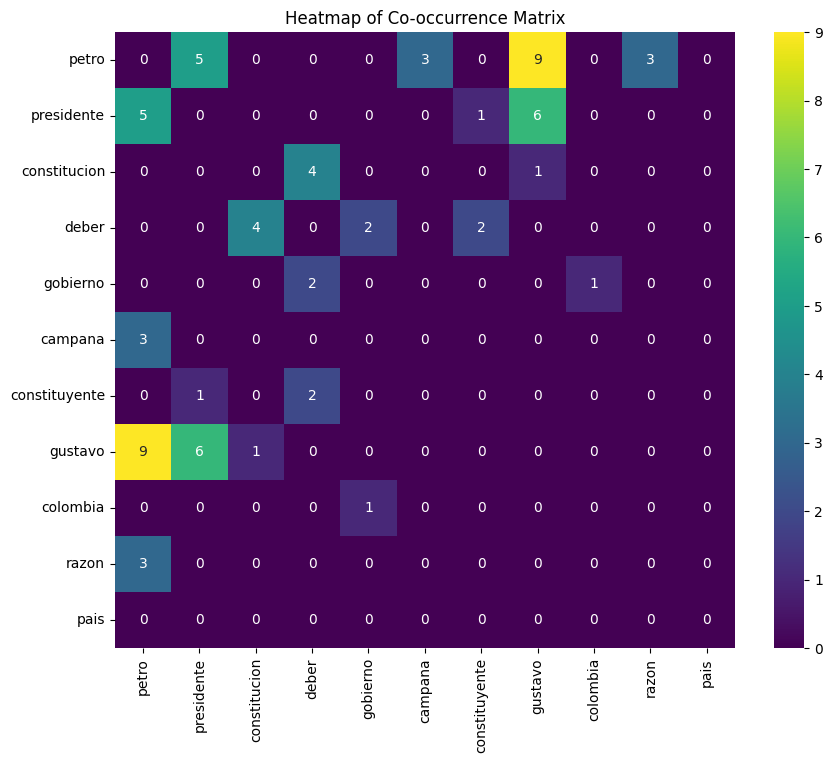

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'co_occurrences_df' is your DataFrame and 'top_matches' is a list or index slice defining the top matches.
# Filter the DataFrame to only include rows and columns from 'top_matches'
sub_matrix = co_ocurrences_df.loc[top_matches.index, top_matches.index]

# Create a heatmap
plt.figure(figsize=(10, 8))  # You can adjust the size to fit your specific needs
sns.heatmap(sub_matrix, annot=True, fmt="d", cmap='viridis')
plt.title('Heatmap of Co-occurrence Matrix')
plt.show()


## Analyzing Contextual Word Relationships Using a Five-Word Window

In [58]:
docs_group = []

# Generate pairs after removing stop words for each document
docs_group.extend([pair for d in documents for pair in generate_ngrams(remove_stop_words(d, spanish_stop_words),5)])

print(docs_group[0:3])

['explicacion narrativa petro red social', 'narrativa petro red social crear', 'petro red social crear segun']


In [59]:
encoding = vectorizer.transform(docs_group).toarray()
co_ocurrences = encoding.T@encoding

names = vectorizer.get_feature_names_out().tolist()

np.fill_diagonal(co_ocurrences, 0)

co_ocurrences_df = pd.DataFrame(co_ocurrences, index=names, columns=names)

In [60]:
top_matches = co_ocurrences_df.sum(axis=1).sort_values(ascending=False).head(11)
top_matches

petro            272
presidente       156
constitucion     140
deber            107
gobierno         100
constituyente     96
gustavo           88
pais              80
publico           80
campana           80
problema          80
dtype: int64

In [62]:
co_ocurrences_df.loc[top_matches.index,top_matches.index]

,petro,presidente,constitucion,deber,gobierno,constituyente,gustavo,pais,publico,campana,problema
petro,0,15,2,0,0,0,17,3,2,6,11
presidente,15,0,0,0,0,3,12,0,0,0,2
constitucion,2,0,0,9,3,1,3,0,0,0,0
deber,0,0,9,0,5,4,0,0,0,0,0
gobierno,0,0,3,5,0,0,0,0,0,0,0
constituyente,0,3,1,4,0,0,0,0,0,0,0
gustavo,17,12,3,0,0,0,0,2,1,0,0
pais,3,0,0,0,0,0,2,0,3,0,8
publico,2,0,0,0,0,0,1,3,0,0,2
campana,6,0,0,0,0,0,0,0,0,0,0


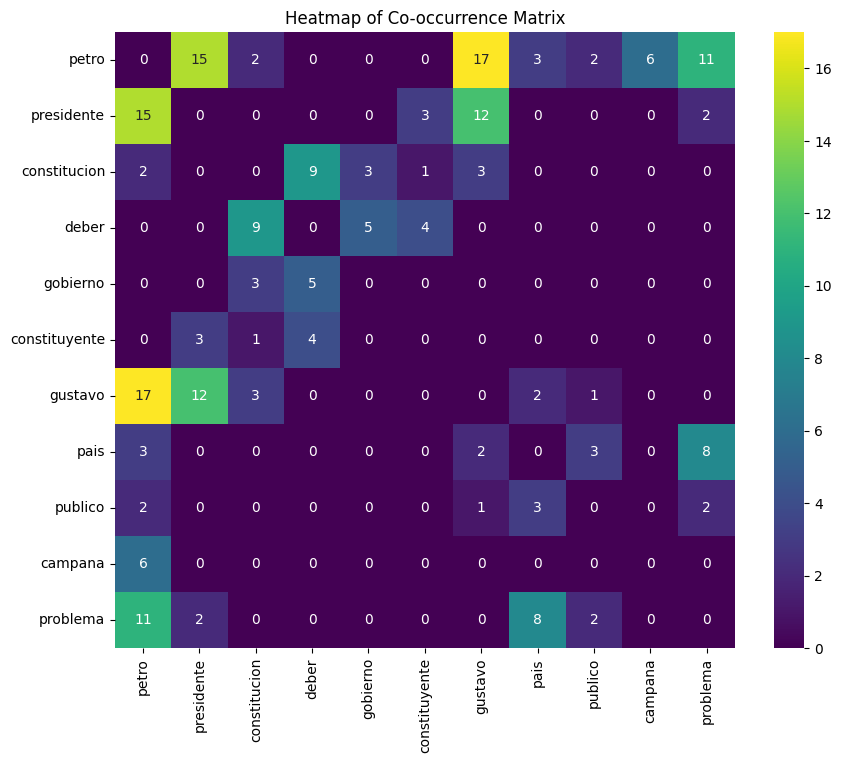

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'co_occurrences_df' is your DataFrame and 'top_matches' is a list or index slice defining the top matches.
# Filter the DataFrame to only include rows and columns from 'top_matches'
sub_matrix = co_ocurrences_df.loc[top_matches.index, top_matches.index]

# Create a heatmap
plt.figure(figsize=(10, 8))  # You can adjust the size to fit your specific needs
sns.heatmap(sub_matrix, annot=True, fmt="d", cmap='viridis')
plt.title('Heatmap of Co-occurrence Matrix')
plt.show()


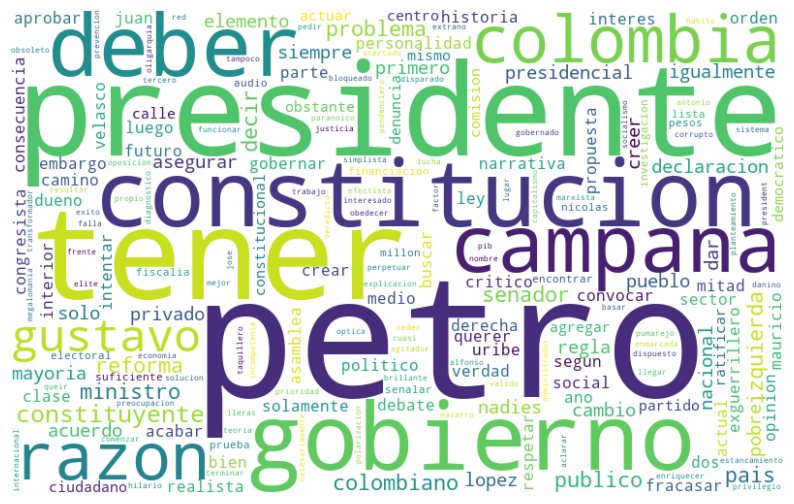

In [70]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re

# Example raw text
raw_text = ' '.join(documents)

# Function to preprocess and compute word frequencies
def calculate_frequencies(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text into words
    words = text.split()
    # Calculate frequencies
    frequencies = Counter(words)
    return frequencies

# Calculate frequencies
word_frequencies = calculate_frequencies(raw_text)

# Generate word cloud
wc = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(word_frequencies)

# Display the word cloud
plt.figure(figsize=(10, 7))  # Size of the plot
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()
